In [2]:
'''
I've assigned a new project: Predicting Employee Turnover. Your task is to develop a predictive model to identify employees likely to leave the company.

'''
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sbn
import lazypredict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score,roc_auc_score #scores metrics measures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #matrix confusion
from xgboost import plot_importance
from lazypredict.supervised import LazyClassifier
import joblib
import shap
import torch
import torch.nn as nn
import torch.utils.data as td
from scipy.stats import shapiro

Loading the data


In [3]:
data= pd.read_csv('./HR_dataset.csv')

Inspecting the data and starting the EDA

In [4]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [6]:
#Let's check for missing values
data.isna().sum()
#There is 0 missing values

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

In [7]:
data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.00,14999.00,14999.00,14999.00,14999.00,14999.00,14999.00,14999.00
mean,0.61,0.72,3.80,201.05,3.50,0.14,0.24,0.02
std,0.25,0.17,1.23,49.94,1.46,0.35,0.43,0.14
min,0.09,0.36,2.00,96.00,2.00,0.00,0.00,0.00
25%,0.44,0.56,3.00,156.00,3.00,0.00,0.00,0.00
50%,0.64,0.72,4.00,200.00,3.00,0.00,0.00,0.00
75%,0.82,0.87,5.00,245.00,4.00,0.00,0.00,0.00
max,1.00,1.00,7.00,310.00,10.00,1.00,1.00,1.00


In the describe I could see the montly average hours is a very high , the normal full-time person should work 40 hours by week , so 40*4= 160 , and the mean in the average_montly_hours 
and the mean in the average_montly_hours is  201,05 which is higher than 160 , so this feature should be important in the analysis.
Let's take a look of average montly hours closer.

In [8]:
data.groupby('left')['average_montly_hours'].mean()

left
0   199.06
1   207.42
Name: average_montly_hours, dtype: float64

We can see that the mean of the average montly hours of the people that stay in the company is lower than the those who left, so the average montly hours could be a good feature to predict if the employee will leave the company.Here we can see also that the average_montly_hours is the feature with the highest difference between

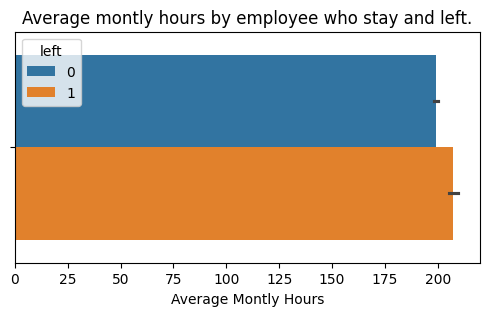

In [9]:

plt.figure(figsize=(6,3))
fig= sbn.barplot(data,x='average_montly_hours',hue='left')
plt.title('Average montly hours by employee who stay and left.')
plt.xlabel('Average Montly Hours')
plt.show()

In [10]:
#To check the others feature order by left
for i in data.drop(['Department','salary','left','average_montly_hours'],axis= 1).columns:
   print(data.groupby('left')[i].mean())

left
0   0.67
1   0.44
Name: satisfaction_level, dtype: float64
left
0   0.72
1   0.72
Name: last_evaluation, dtype: float64
left
0   3.79
1   3.86
Name: number_project, dtype: float64
left
0   3.38
1   3.88
Name: time_spend_company, dtype: float64
left
0   0.18
1   0.05
Name: Work_accident, dtype: float64
left
0   0.03
1   0.01
Name: promotion_last_5years, dtype: float64


Here we can see that the employees who stay has a mean() of promotion_last_5_years,satisfaction_level,work_accident higer than those who left but this is logically normal

In [11]:
data.groupby('left')['number_project'].value_counts()

left  number_project
0     3                 3983
      4                 3956
      5                 2149
      2                  821
      6                  519
1     2                 1567
      6                  655
      5                  612
      4                  409
      7                  256
      3                   72
Name: count, dtype: int64

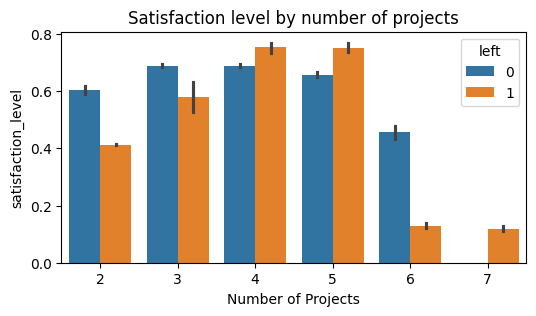

In [12]:
plt.figure(figsize=(6,3))
sbn.barplot(data, x= 'number_project',y='satisfaction_level', hue='left')
plt.title('Satisfaction level by number of projects')
plt.xlabel('Number of Projects')
plt.show()

Here we can see that there is not a single employee who stayed that has 7 projects and by the other hand there are 256 employees that have 7 projects
Also we can see that the satisfaction lvl start to decrease with the 6 projects

In [13]:
data[data['number_project']>5].groupby('left')['satisfaction_level'].mean()

left
0   0.46
1   0.13
Name: satisfaction_level, dtype: float64

You can notice the obvius difference between the satisfaction lvl of those who stayed and left with more than 5 projects
So the number_project feature could be an important feature for further analysis. 

Let's check the salary and Department features

In [14]:
data[['salary']].value_counts() # There're 5 times more employees with low and medium salary thatn employees with high salary

salary
low       7316
medium    6446
high      1237
Name: count, dtype: int64

In [15]:
data[['Department']].value_counts()#the Department with more employees is sales and the less employees is management

Department 
sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: count, dtype: int64

In [16]:
round(data.groupby('salary')['left'].value_counts(normalize=True)*100,3)
#Only the 6.62% of employees with high salary left there is a big difference with low (29.68 left) and medium (20.43 left)

salary  left
high    0      93.37
        1       6.63
low     0      70.31
        1      29.69
medium  0      79.57
        1      20.43
Name: proportion, dtype: float64

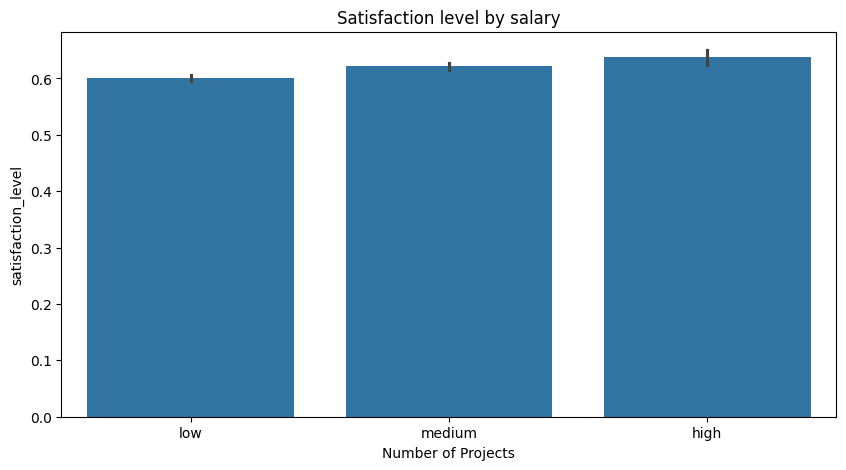

In [17]:
plt.figure(figsize=(10,5))
sbn.barplot(data,x='salary', y= 'satisfaction_level')
plt.title('Satisfaction level by salary')
plt.xlabel('Number of Projects')
plt.show()

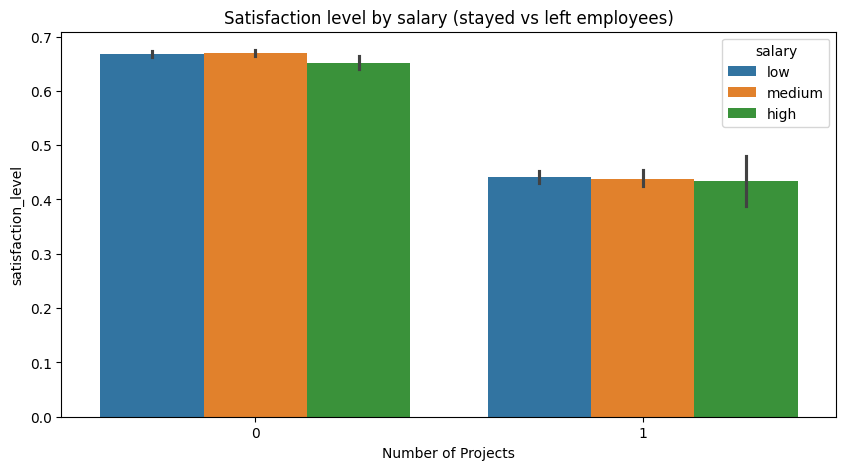

In [18]:
plt.figure(figsize=(10,5))
sbn.barplot(data,x='left', y= 'satisfaction_level',hue= 'salary')
plt.title('Satisfaction level by salary (stayed vs left employees)')
plt.xlabel('Number of Projects')
plt.show()

In [19]:
round(data.groupby(['salary','left'])['Department'].value_counts(normalize=True)*100,3)

salary  left  Department 
high    0     sales         22.08
              management    19.39
              technical     15.24
              support       11.52
              IT             6.84
              marketing      6.15
              accounting     5.97
              product_mng    5.37
              RandD          4.07
              hr             3.38
        1     technical     30.49
              sales         17.07
              marketing     10.98
              support        9.76
              hr             7.32
              product_mng    7.32
              accounting     6.10
              RandD          4.88
              IT             4.88
              management     1.22
low     0     sales         27.25
              technical     19.32
              support       14.72
              IT             8.49
              product_mng    6.73
              RandD          6.01
              marketing      5.37
              accounting     5.04
              hr      

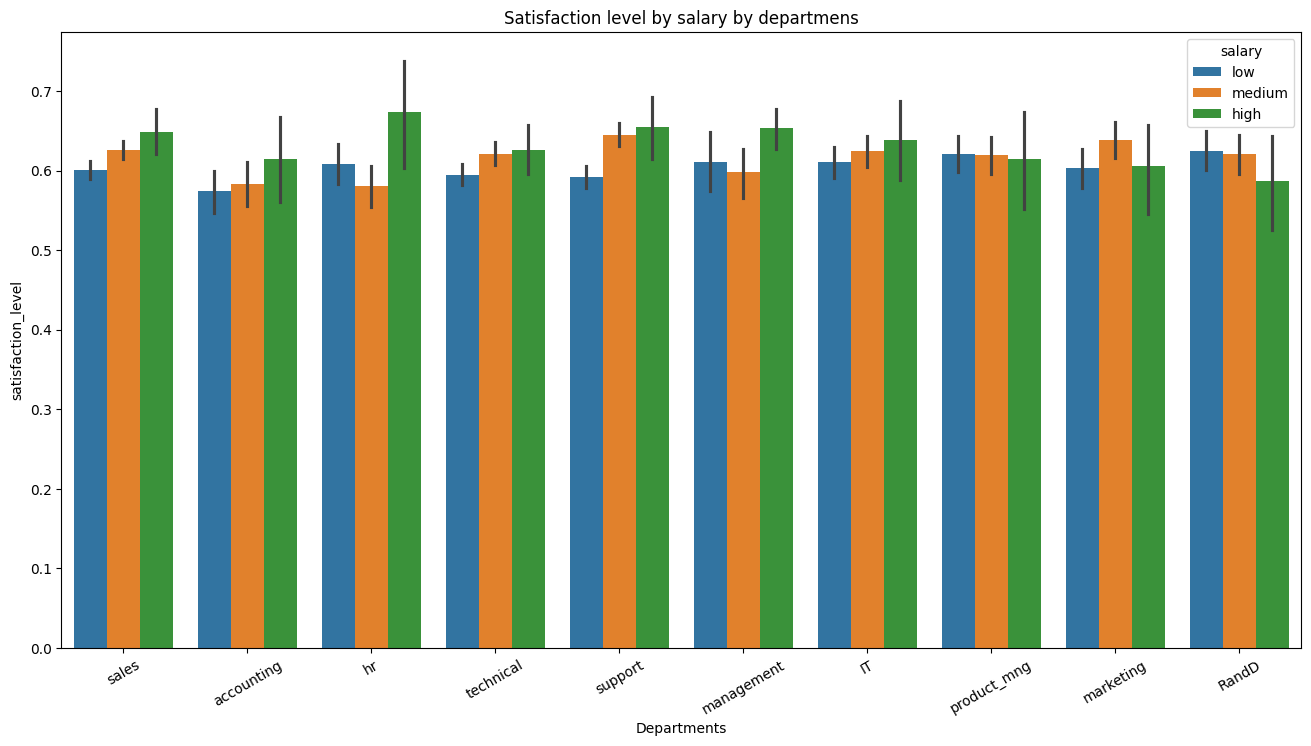

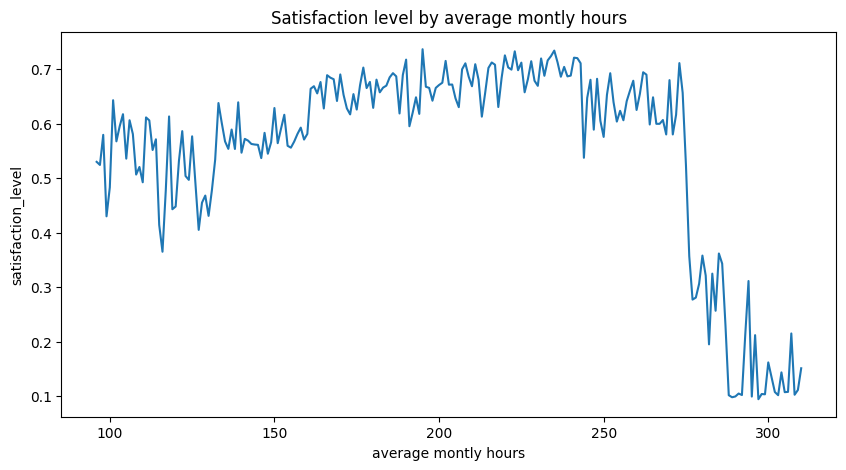

In [20]:
plt.figure(figsize=(16,8))
sbn.barplot(data,x= 'Department',y= 'satisfaction_level',hue= 'salary')
plt.title('Satisfaction level by salary by departmens')
plt.xlabel('Departments')
plt.xticks(rotation= 30)
plt.show()
# 6 of 10 have employees with low salary  that the satisfaction level is lower than medium and high salaries  
plt.figure(figsize=(10,5))
sbn.lineplot(data.groupby(['average_montly_hours'])['satisfaction_level'].mean())
plt.title('Satisfaction level by average montly hours')
plt.xlabel('average montly hours')
plt.show()
#We can see here that more hours will have less satisfaction lvl

Now is time to encode before check the correlations

In [21]:
df= data.copy()

In [22]:
df= df.rename(columns={'Department':'department'})

In [23]:
df['salary'].unique()

array(['low', 'medium', 'high'], dtype=object)

In [24]:
df['salary']= df['salary'].map({'low':1,'medium':2,'high':3})

In [25]:
df['department'].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

In [26]:
df['department']= df['department'].map({'sales':1, 'accounting':2, 'hr':3, 'technical':4, 'support':5, 'management':6,
       'IT':7, 'product_mng':8, 'marketing':9, 'RandD':10})
#Now it's time for check for outliers and normal distribution
#Then we define the function get_boxPlot that get the feature name and the show a histplot to
#check how is distributed
def get_boxPlot(d):
    feature= str(d).replace("_"," ")
    plt.figure(figsize=(5,2))
    sbn.boxplot(x=df[d])
    plt.title(f"Box Plot of :{feature}")
    plt.xlabel(feature)
    plt.show()

First we check for outliers

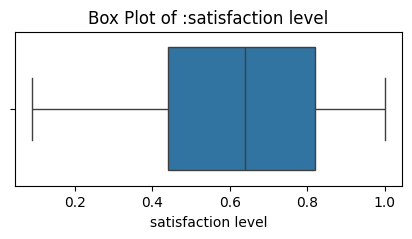

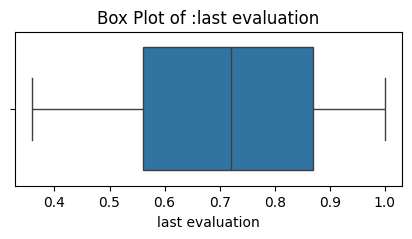

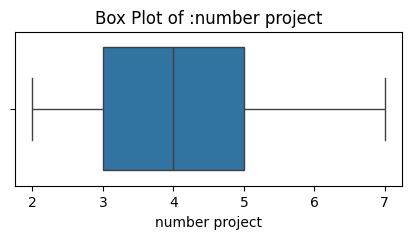

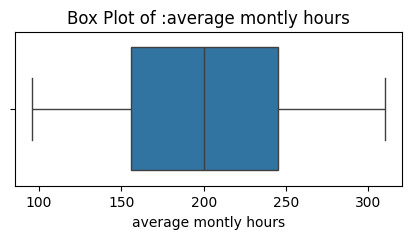

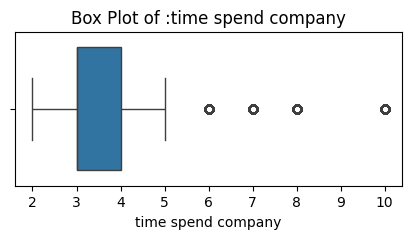

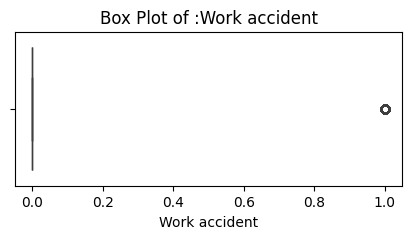

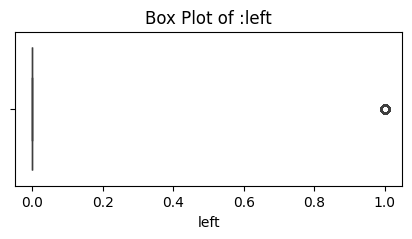

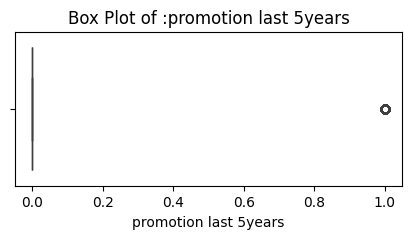

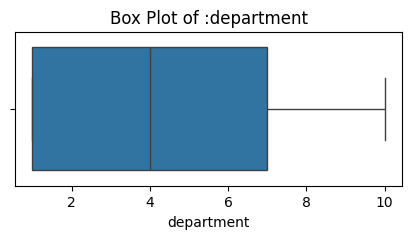

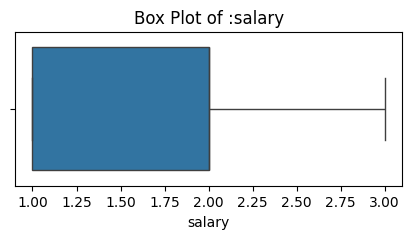

In [27]:
for i in df.columns:
    get_boxPlot(i)

We can see that there are outliers in the time spend company but that could be some of the older employee so we gonna let pass that

Now we check for normal distribution
I'll perform Shapiro-Wilk test for normality

In [28]:
def get_normality(d):
    #If the p-value is less than 0.05, we reject the null hypothesis of normality
    normality= shapiro(df[d])
    if normality.pvalue < 0.05:
        print("Is normally distributed!")
    else:
        print("Is not normally distributed!")

In [29]:
for i in df.columns:
    get_normality(i)

Is normally distributed!
Is normally distributed!
Is normally distributed!
Is normally distributed!
Is normally distributed!
Is normally distributed!
Is normally distributed!
Is normally distributed!
Is normally distributed!
Is normally distributed!


We get that all the features are normally distributed

Let's check the correlation between the features

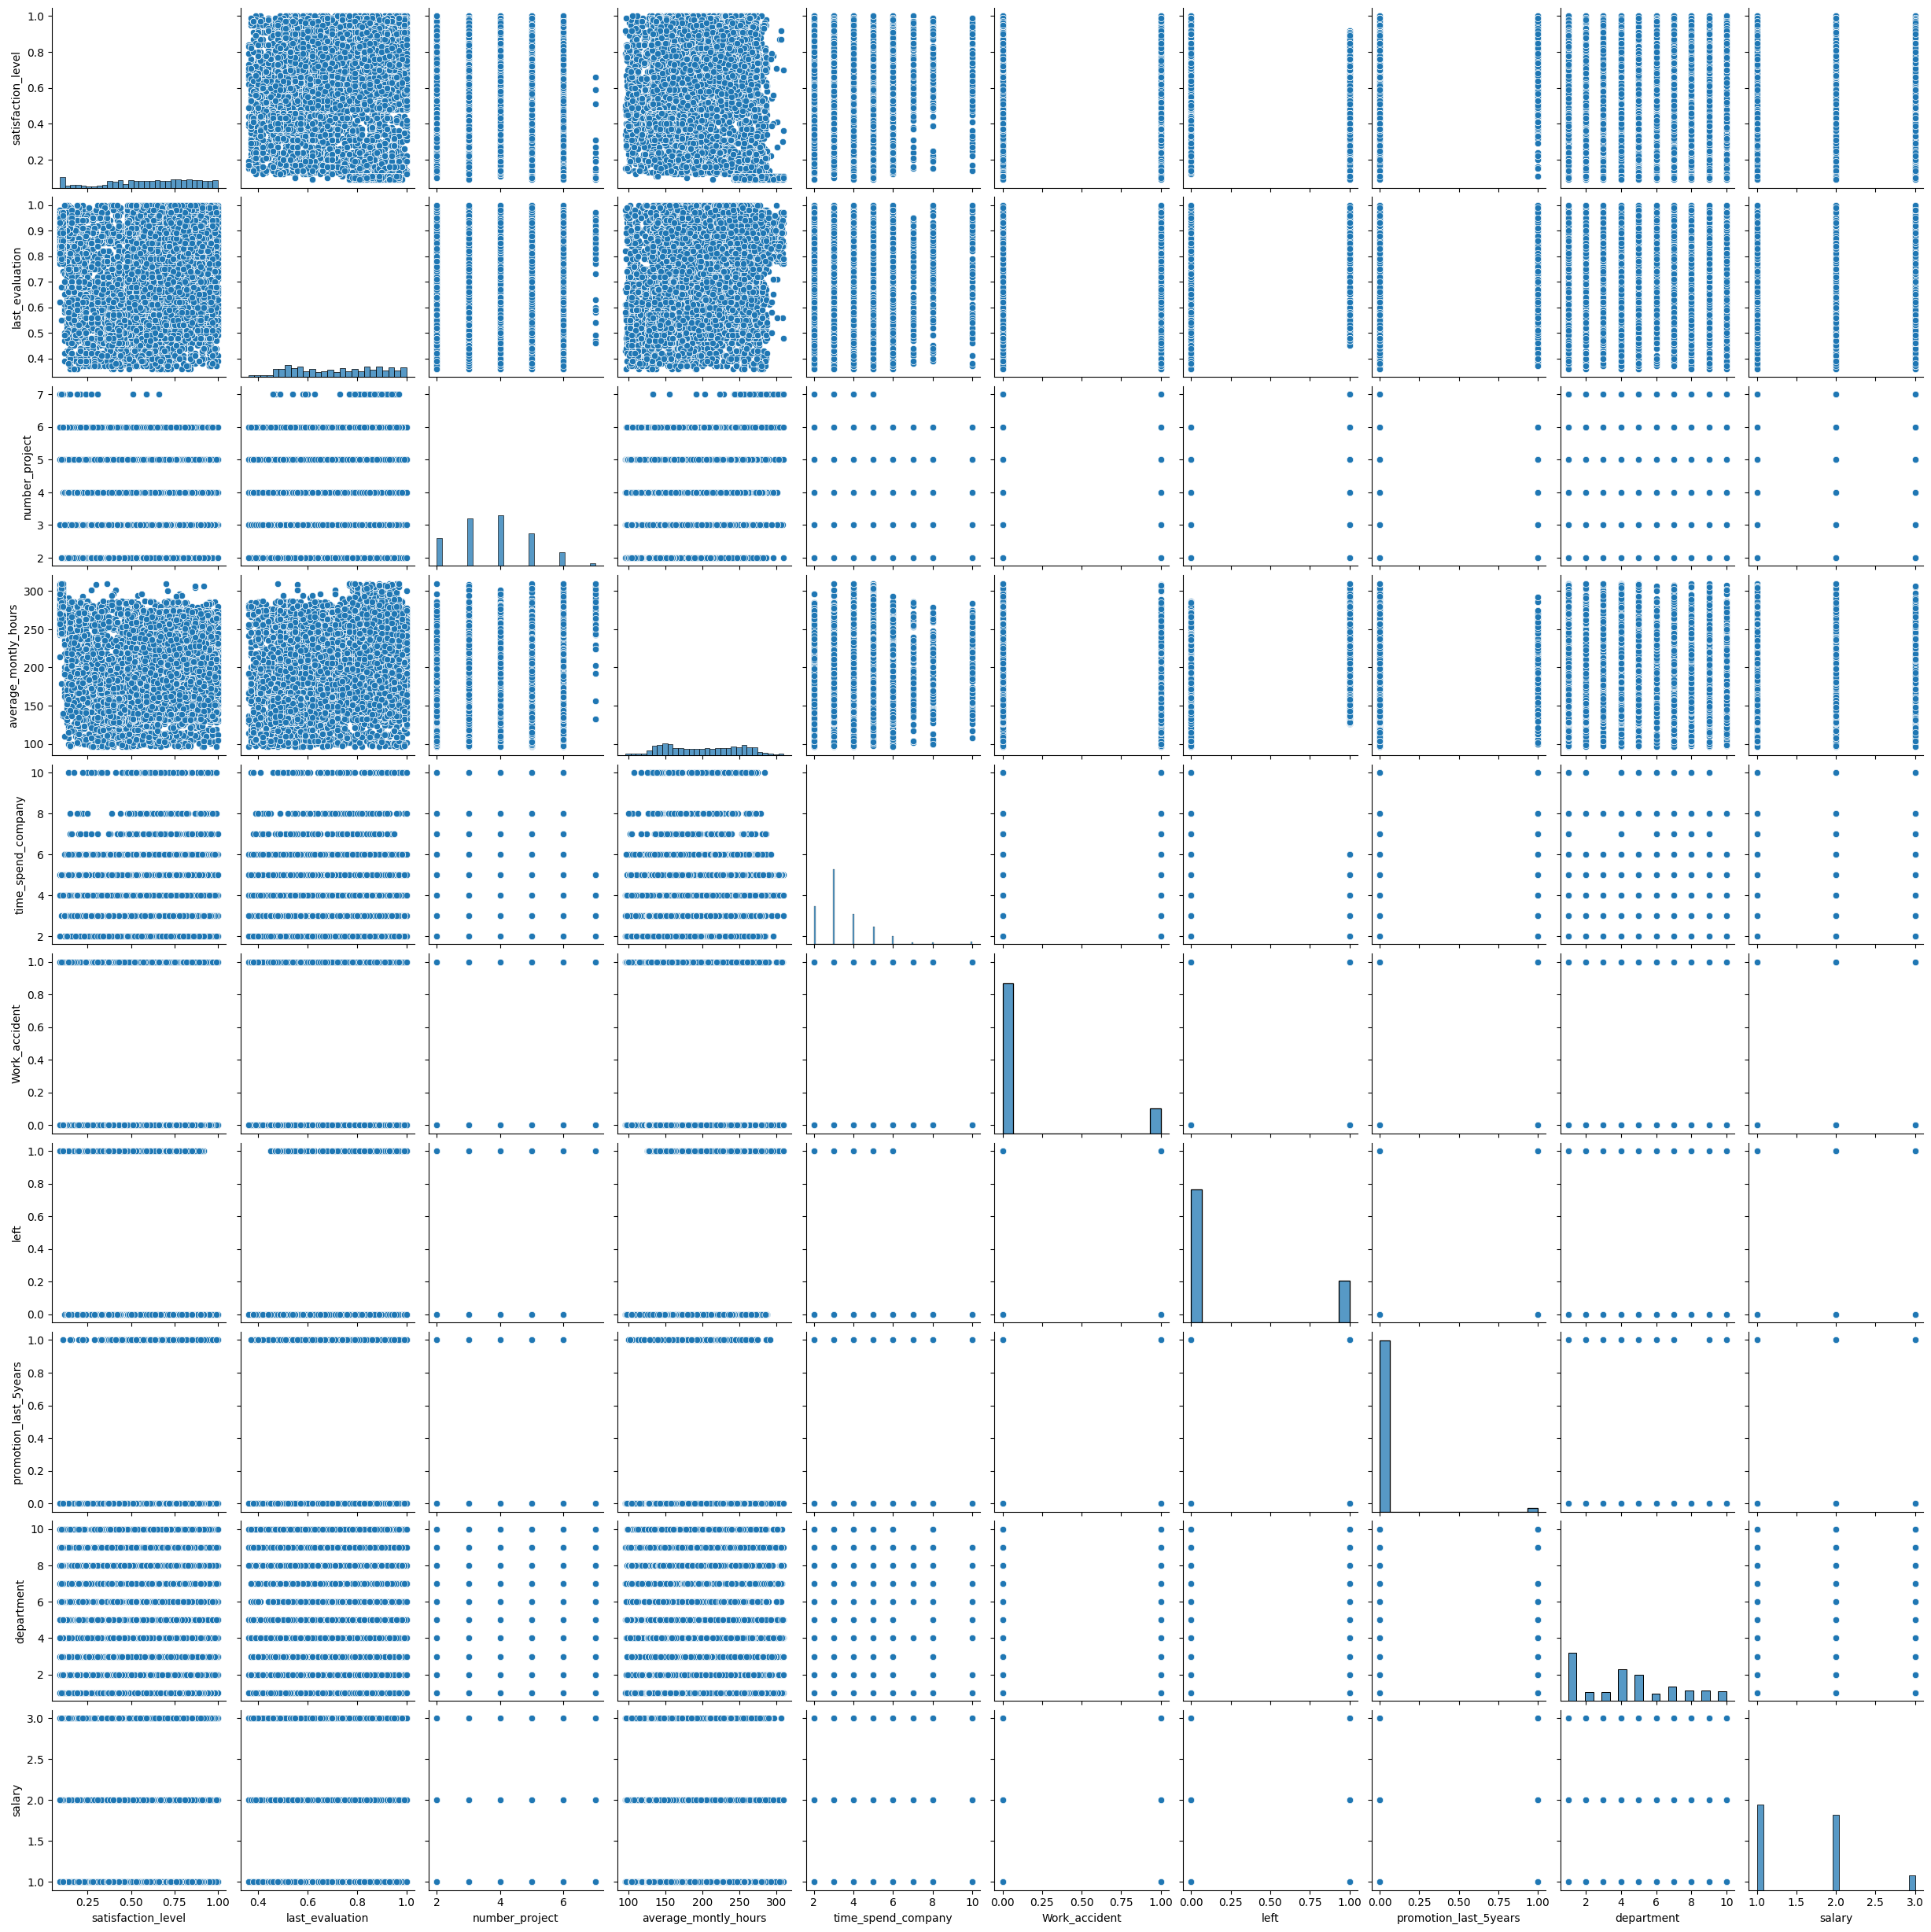

In [30]:
sbn.pairplot(df)

Left don't have a strong relation with work accident or promotion_last_5years 

We can start now to prepare the data for the modeling

In [31]:
X= df.drop('left',axis= 1)
y= df['left']

In [32]:
X_tr,X_test,y_tr,y_test= train_test_split(X.values,y.values,random_state=42,test_size=0.20, stratify=y)

In [33]:
X_train,X_validation,y_train,y_validation= train_test_split(X_tr,y_tr,random_state=42,test_size=0.20,stratify=y_tr)

In [34]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

In [35]:
models,predictions = clf.fit(X_train, X_validation, y_train, y_validation)

 97%|█████████▋| 30/31 [00:20<00:00,  1.84it/s]

[LightGBM] [Info] Number of positive: 2286, number of negative: 7313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 9599, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238150 -> initscore=-1.162850
[LightGBM] [Info] Start training from score -1.162850


100%|██████████| 31/31 [00:21<00:00,  1.45it/s]


In [36]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.99,0.98,0.98,0.99,0.79
XGBClassifier,0.99,0.98,0.98,0.99,0.43
ExtraTreesClassifier,0.99,0.98,0.98,0.99,1.18
LGBMClassifier,0.99,0.98,0.98,0.99,0.65
BaggingClassifier,0.99,0.97,0.97,0.99,0.46
DecisionTreeClassifier,0.98,0.97,0.97,0.98,0.09
LabelPropagation,0.97,0.97,0.97,0.97,5.70
LabelSpreading,0.97,0.97,0.97,0.97,7.52
ExtraTreeClassifier,0.97,0.96,0.96,0.97,0.04


After make a lazyClassifier that involves some of the models 
We could see here that the best models with the highest metrics (accuracy, precision, recall, F1-score, AUC-ROC)  are RandomForestClassifier and XGBClassifier now we gonna check again those scores

In [37]:
def get_test_scores(model_name:str, preds, y_test_data,model):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    aucu= round(roc_auc_score(y_test_data,preds),5)
    accuracy = round(accuracy_score(y_test_data, preds),5)
    precision = round(precision_score(y_test_data, preds),5)
    recall = round(recall_score(y_test_data, preds),5)
    f1 = round(f1_score(y_test_data, preds),5)          
    

    table = pd.DataFrame({'Model': [model_name],
                          'Precision': [precision*100],
                          'Recall': [recall*100],
                          'F1': [f1*100],
                          'Accuracy': [accuracy*100],
                          'Auc': [aucu*100]
                        })

    return table

In [38]:
def  confuMatrix_plot(model,x_data_test,y_data_test):
                    
                     pred= model.predict(x_data_test)

                     cm = confusion_matrix(y_data_test, pred)

                     # Create the display for your confusion matrix.

                     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

                     # Plot the visual in-line.
                     
                     disp.plot(values_format='')  # `values_format=''` suppresses scientific notation

                     disp.plot()

In [39]:
randomForest_clf= RandomForestClassifier(random_state=42)

In [40]:
randomForest_clf.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [41]:
predicts_randomForest_clf_validation= randomForest_clf.predict(X_validation)

In [42]:
results_validation= get_test_scores('RandomForest_clf',predicts_randomForest_clf_validation,y_validation,randomForest_clf)

In [43]:
results_validation

,Model,Precision,Recall,F1,Accuracy,Auc
0,RandomForest_clf,99.64,96.67,98.13,99.12,98.28


In [44]:
#We can see here a precision and accuracy of 99 , recall 96 , f1 and Auc 98 that this means that the model is was very good with the validation set
#Now let's see whit the test set.
results_test= get_test_scores('RandomForest_clf',randomForest_clf.predict(X_test),y_test,randomForest_clf)
#We can see the same metrics for the model so this could be a champion model

In [45]:
#Now let's try with the XGB
xgb_clf = XGBClassifier(objective='binary:logistic', random_state=42)

In [46]:
xgb_clf.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [48]:
results_validation= pd.concat([results_validation,get_test_scores('XGBoost_clf',xgb_clf.predict(X_validation),y_validation,xgb_clf)])
#We can see here a precisiont and accuracy of 98 , recall 96 , f1 97 and Auc 98 that this means that the model is was very good with the validation set but the metrics are little bit lower than RandomForest
#Now let's see whit the test set.

In [49]:
results_validation

,Model,Precision,Recall,F1,Accuracy,Auc
0,RandomForest_clf,99.64,96.67,98.13,99.12,98.28
0,XGBoost_clf,98.57,96.50,97.52,98.83,98.03


In [50]:
results_test= pd.concat([results_test,get_test_scores('XGboos_clf_clf',xgb_clf.predict(X_test),y_test,xgb_clf)])

In [51]:
results_test

,Model,Precision,Recall,F1,Accuracy,Auc
0,RandomForest_clf,99.57,96.50,98.01,99.07,98.18
0,XGboos_clf_clf,98.56,96.08,97.30,98.73,97.82
0,XGboos_clf_clf,98.56,96.08,97.30,98.73,97.82


The result is similar there are a little bit lower than RandomForest Classifier

Now lets try with hypertunning and cv for both

In [52]:
cv_rf_params = {'max_depth': [2,3,4,5, None], 
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [75, 100, 125, 150]
             }  

In [53]:
scoring = ['accuracy', 'precision', 'recall', 'f1']

In [54]:
RandomForest_CV= GridSearchCV(randomForest_clf,cv_rf_params,scoring= scoring, cv= 5, refit= 'f1')

In [ ]:
RandomForest_CV.fit(X_train,y_train)

In [65]:
pred_rf_cv= RandomForest_CV.best_estimator_.predict(X_validation)

In [66]:
results_validation= pd.concat([results_validation,get_test_scores('RandomForestCV',pred_rf_cv,y_validation,RandomForest_CV)],axis=0)

In [68]:
results_validation

,Model,Precision,Recall,F1,Accuracy,Auc
0,RandomForest_clf,99.64,96.67,98.13,99.12,98.28
0,XGBoost_clf,98.57,96.50,97.52,98.83,98.03
0,RandomForestCV,99.82,96.50,98.13,99.12,98.22


We can see here that Random Forest with tuning and Cross validation has better performance than the others models

In [56]:
path= './Models/'

In [ ]:
joblib.dump(RandomForest_CV,path+'modelTree.pkl')

In [63]:
#To load use:
loaded_RandomForest_CV= joblib.load(path+'RandomForest_CV.pkl')

Now It's time to get the features with more importance at the time of predict if they will stay or left

In [67]:
importance= loaded_RandomForest_CV.best_estimator_.feature_importances_ #Get the feature importance values
#Make a DataFrame with the values and the names of each feature to see the importance
df_importance= pd.DataFrame(data=importance,index=X.columns, columns=['Importance']).sort_values(by='Importance',ascending=False)

In [69]:
df_importance= df_importance.rename_axis('Features').reset_index()

In [70]:
df_importance

,Features,Importance
0,satisfaction_level,0.36
1,number_project,0.18
2,time_spend_company,0.18
3,average_montly_hours,0.14
4,last_evaluation,0.12
5,department,0.01
6,salary,0.01
7,Work_accident,0.00
8,promotion_last_5years,0.00


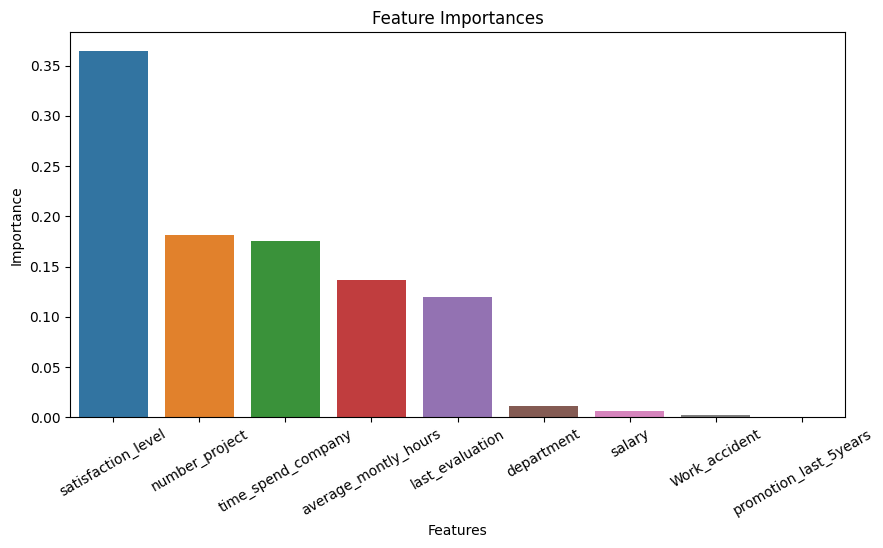

In [73]:
plt.figure(figsize=(10,5))
sbn.barplot(df_importance,x='Features',y='Importance',hue='Features')
plt.title('Feature Importances')
plt.xticks(rotation= 30)
plt.show()

As we can see and we already analyzed early with the graphs the features that can have a significanse are:
satisfaction_level, number_project,time_spend_company adn average_montly_hours.

But if we analyze a detail the results:

In [74]:
shap.initjs()

In [75]:
explainer_randomForest_CV= shap.Explainer(loaded_RandomForest_CV.best_estimator_.predict,X_train)

In [ ]:
shap_values_xgb= explainer_randomForest_CV(X_test)

ExactExplainer explainer:  17%|█▋        | 524/3000 [03:39<09:13,  4.48it/s]

In [ ]:
shap.summary_plot(shap_values_xgb, X_test,feature_names=X.columns)

Here we can see cleary that it they are the same 5 important features but satisfaction_level , number_project and average_hours are coorelated
and that with high values of number_project and average_montly_hours we get low values of satisfaction_level
and then we can start a teory that with more projects and more hours in the week the satisfaction_level 
will drop in the employees and will grow up the posibilities of left, so the recomends should be try to not overcharge the employees with
projects and hours in the week.